In [0]:
!pip install tensorflow==2.0.0b1


In [1]:
import tensorflow as tf
print(tf.__version__)


2.0.0-dev20191002


The next code block will set up the time series with seasonality, trend and a bit of noise. 

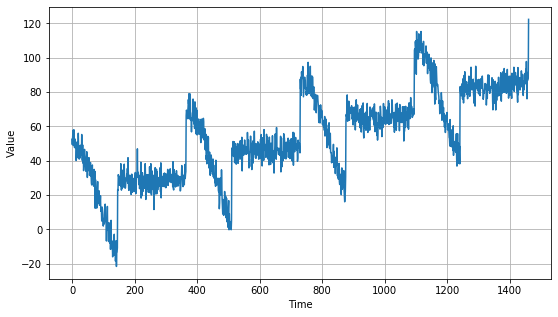

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(9, 5))
plot_series(time, series)
plt.show()

## 1. Split Dataset

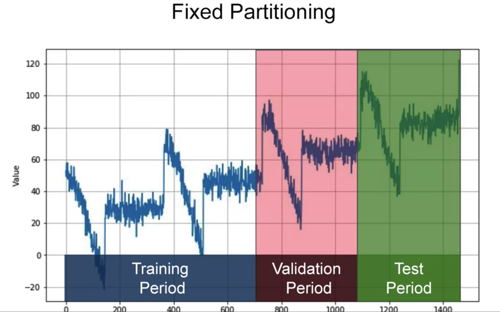

If the time series has some seasonality, you generally want to ensure that each period contains a whole number of seasons. You'll train your model on the training period, and you'll evaluate it on the validation period. Here's where you can experiment to find the right architecture for training. And work on it and your hyper parameters, until you get the desired performance, measured using the validation set. Often, once you've done that, you can retrain using both the training and validation data. And then test on the test period to see if your model will perform just as well. 

And if it does, then you could take the unusual step of retraining again, using also the test data. But why would you do that? Well, it's because the test data is the closest data you have to the current point in time. And as such it's often the strongest signal in determining future values. If your model is not trained using that data, too, then it may not be optimal. 

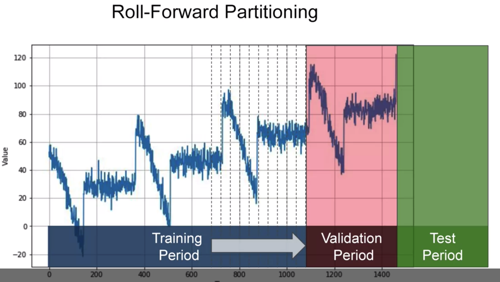

We start with a short training period, and we gradually increase it, say by one day at a time, or by one week at a time. At each iteration, we train the model on a training period. And we use it to forecast the following day, or the following week, in the validation period.

## 2. Metrix

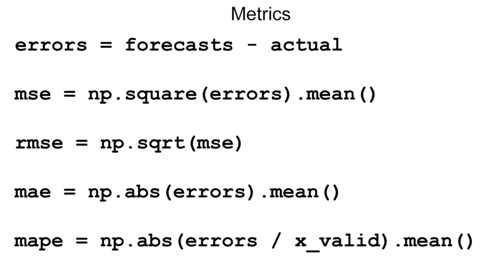

- MSE, mean square errors, get rid of negative values
- RMSE:  if we want the mean of our errors' calculation to be of the same scale as the original errors, then we just get its square root, giving us a root means squared error or rmse. 
- MAE: mean absolute error or mae, and it's also called the main absolute deviation or mad. And in this case, instead of squaring to get rid of negatives, it just uses their absolute value. This does not penalize large errors as much as the mse does. 

If large errors are potentially dangerous and they cost you much more than smaller errors, then you may prefer the mse. But if your gain or your loss is just proportional to the size of the error, then the mae may be better.

- MAPE: mean ratio between the absolute error and the absolute value, this gives an idea of the size of the errors compared to the values.

## 3. Forecast

A commen and very sample forecasting method - Moving Average.

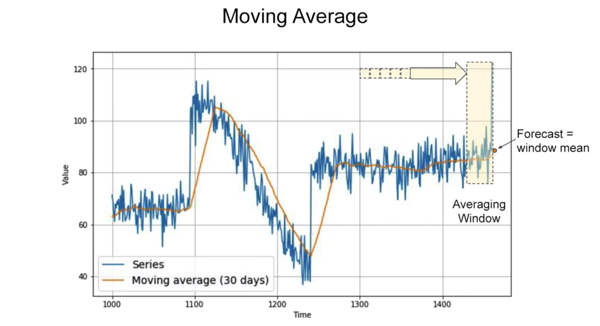

The idea here is that the yellow line is a plot of the average of the blue values over a fixed period called an averaging window, for example, 30 days. Now this nicely eliminates a lot of the noise and it gives us a curve roughly emulating the original series, but it does not anticipate trend or seasonality. Depending on the current time i.e. the period after which you want to forecast for the future, it can actually end up being worse than a naive forecast. In this case, for example, I got a mean absolute error of about 7.14. 

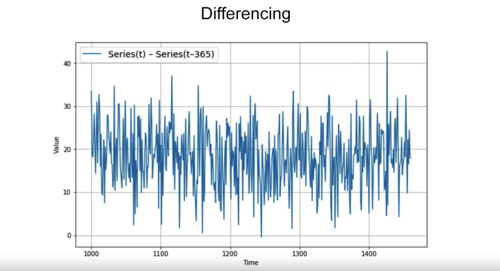

One method to avoid this is to remove the trend and seasonality from the time series with a technique called differencing. So instead of studying the time series itself, we study the difference between the value at time T and the value at an earlier period. Depending on the time of your data, that period might be a year, a day, a month or whatever. Let's look at a year earlier. So for this data, at time T minus 365, we'll get this difference time series which has no trend and no seasonality. 

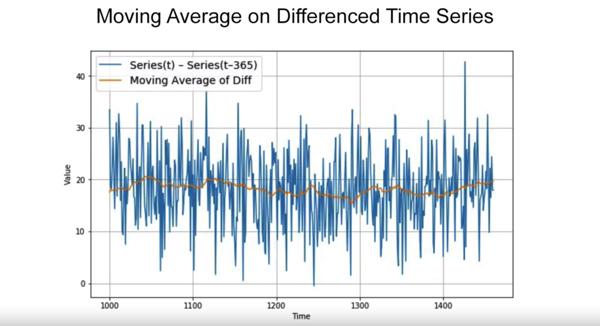

We can then use a moving average to forecast this time series which gives us these forecasts. But these are just forecasts for the difference time series, not the original time series. To get the final forecasts for the original time series, we just need to add back the value at time T minus 365, and we'll get these forecasts. 

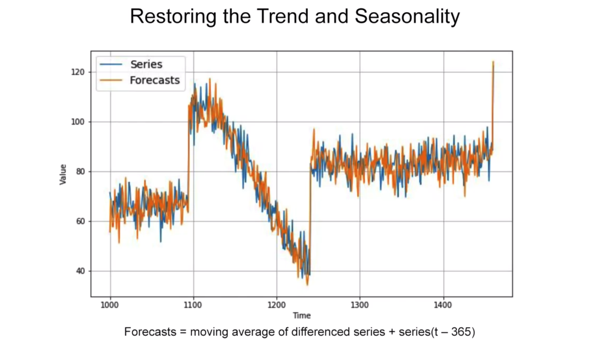

They look much better, don't they? If we measure the mean absolute error on the validation period, we get about 5.8. So it's slightly better than naive forecasting but not tremendously better. 

If we measure the mean absolute error on the validation period, we get about 5.8. So it's slightly better than naive forecasting but not tremendously better. You may have noticed that our moving average removed a lot of noise but our final forecasts are still pretty noisy. Where does that noise come from? Well, that's coming from the past values that we added back into our forecasts. So we can improve these forecasts by also removing the past noise using a moving average on that. 

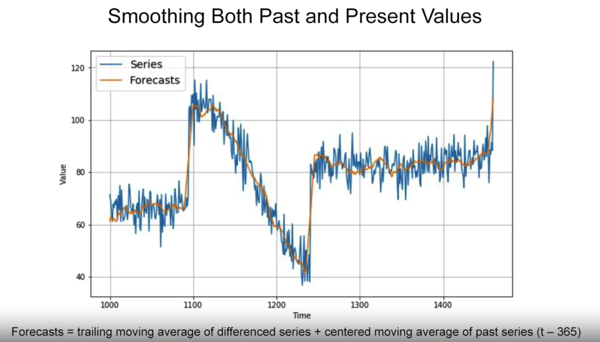

If we do that, we get much smoother forecasts. In fact, this gives us a mean squared error over the validation period of just about 4.5. Now that's much better than all of the previous methods. In fact, since the series is generated, we can compute that a perfect model will give a mean absolute error of about four due to the noise. Apparently, with this approach, we're not too far from the optimal. 

Note that when we use the trailing window when computing the moving average of present values from t minus 32, t minus one. But when we use a centered window to compute the moving average of past values from one year ago, that's t minus one year minus five days, to t minus one year plus five days. Then moving averages using centered windows can be more accurate than using trailing windows. But we can't use centered windows to smooth present values since we don't know future values. However, to smooth past values we can afford to use centered windows.

Now that we have the time series, let's split it so we can start forecasting

## 4. Practice

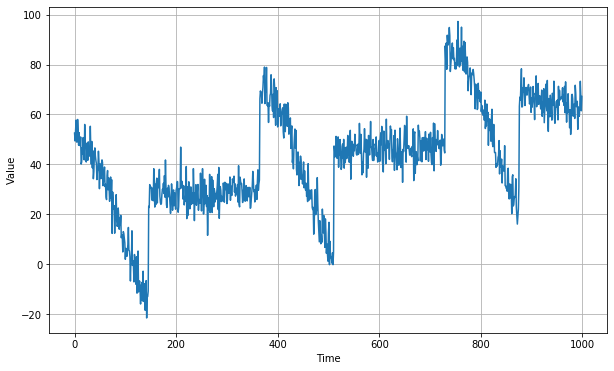

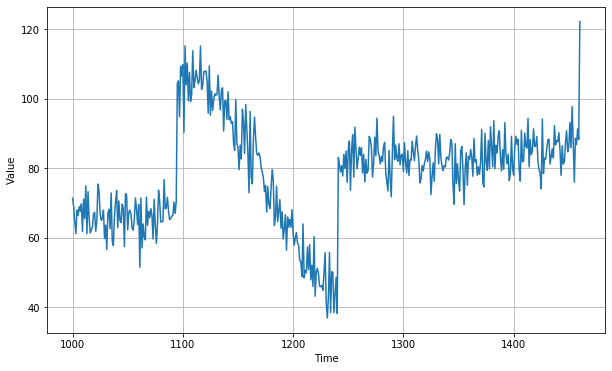

In [7]:
# split train and valid
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [8]:
# Naive Forecast

In [9]:
# just predict the value at time period plus 1
naive_forecast = series[split_time - 1:-1]

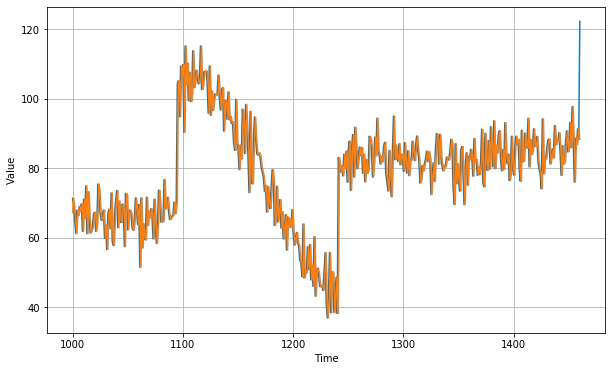

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Let's zoom in on the start of the validation period:

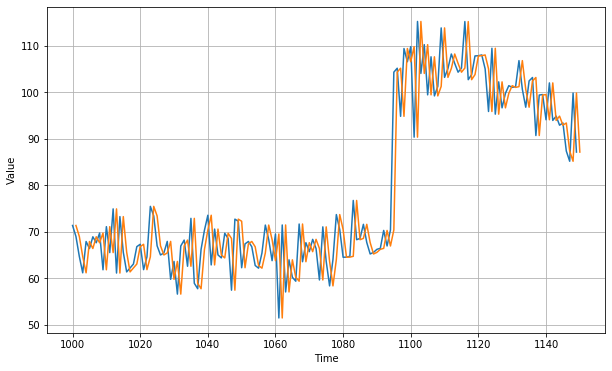

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)
# the orange data is just one step after the blue data.

You can see that the naive forecast lags 1 step behind the time series.

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [12]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
# MAE
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827538
5.937908


That's our baseline, now let's try a moving average:

In [13]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

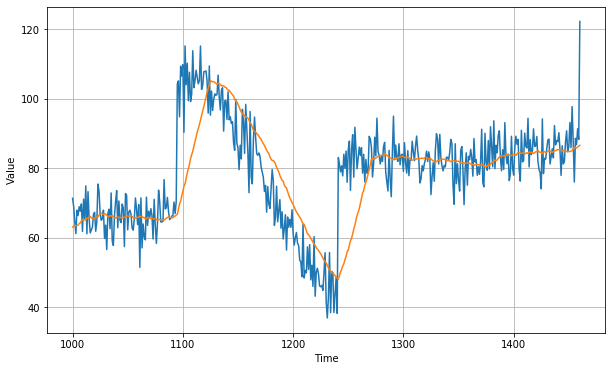

In [14]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [15]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
# worse than the naive prediction

106.674576
7.142419


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

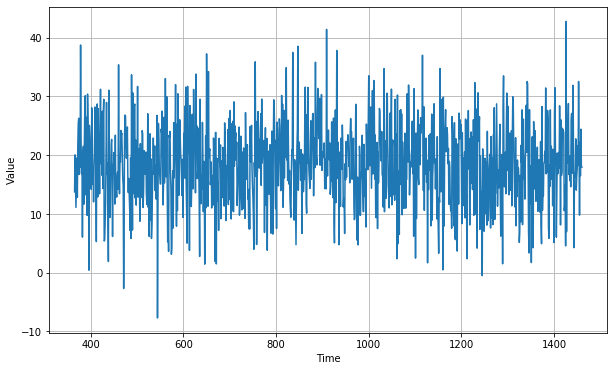

In [16]:
# difference between time t and 365 days before that 
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()
# the seasonality is gone

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

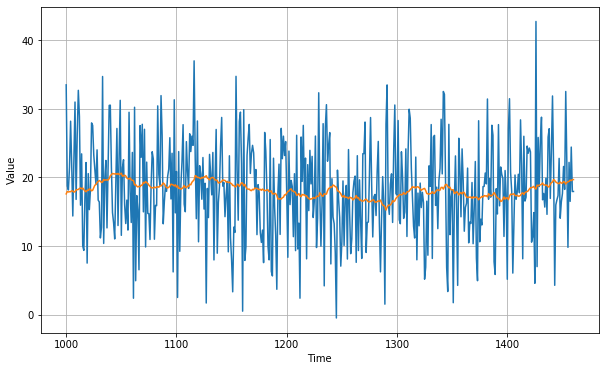

In [17]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

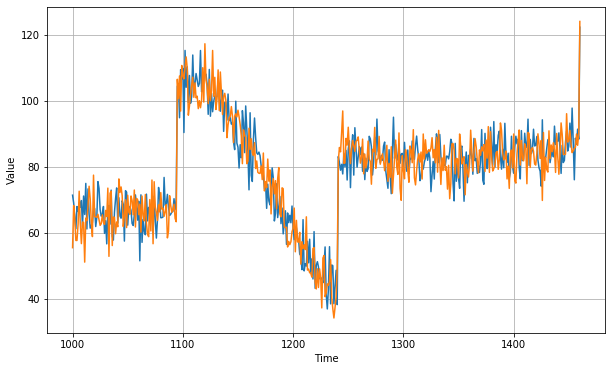

In [18]:
# adding back the past value
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [19]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.97366
5.839311


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

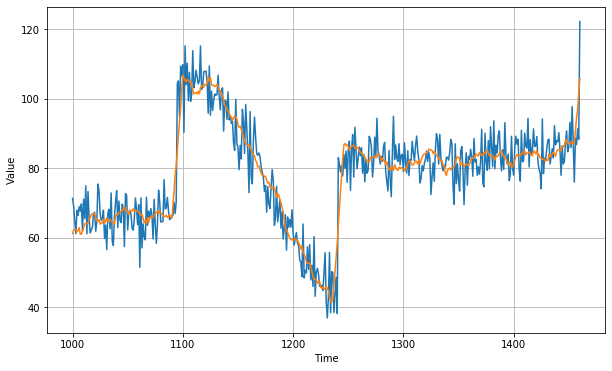

In [20]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [21]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.45226
4.569442
